# COVID-19 Xray Dataset (Train & Test Sets)

### Source : https://www.kaggle.com/khoongweihao/covid19-xray-dataset-train-test-sets


### Description :

- The 2019 novel coronavirus (COVID-19) presents several unique features. While the diagnosis is confirmed using polymerase chain reaction (PCR), infected patients with pneumonia may present on chest X-ray and computed tomography (CT) images with a pattern that is only moderately characteristic for the human eye Ng, 2020. COVID-19’s rate of transmission depends on our capacity to reliably identify infected patients with a low rate of false negatives. In addition, a low rate of false positives is required to avoid further increasing the burden on the healthcare system by unnecessarily exposing patients to quarantine if that is not required. Along with proper infection control, it is evident that timely detection of the disease would enable the implementation of all the supportive care required by patients affected by COVID-19.

- In late January, a Chinese team published a paper detailing the clinical and paraclinical features of COVID-19. They reported that patients present abnormalities in chest CT images with most having bilateral involvement Huang 2020. Bilateral multiple lobular and subsegmental areas of consolidation constitute the typical findings in chest CT images of intensive care unit (ICU) patients on admission Huang 2020. In comparison, non-ICU patients show bilateral ground-glass opacity and subsegmental areas of consolidation in their chest CT images Huang 2020. In these patients, later chest CT images display bilateral ground-glass opacity with resolved consolidation Huang 2020.

- COVID is possibly better diagnosed using radiological imaging Fang, 2020 and Ai 2020.

### Importing required Utilities

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mounting Google drive

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Listing data and Dataframe creation

In [0]:
#Google drive path to images
path = "/content/drive/My Drive/Temp/"

#Training Images
train_norm = os.listdir(path + "train/NORMAL")
train_covid = os.listdir(path + "train/PNEUMONIA")

#Testing Images
test_norm = os.listdir(path + "test/NORMAL")
test_covid = os.listdir(path + "test/PNEUMONIA")

In [0]:
#Dataframe function
def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

#Forming Train and Test Dataframe
train_norm_df = dataframe(train_norm, 'Normal')
train_covid_df = dataframe(train_covid, 'Covid')

test_norm_df = dataframe(test_norm, 'Normal')
test_covid_df = dataframe(test_covid, 'Covid')

#Concating both classes into single datarame
train_df = pd.concat([train_norm_df, train_covid_df], axis=0)
test_df = pd.concat([test_norm_df, test_covid_df], axis=0)

In [5]:
#Path maker function
def pathmaker(df_name, df, empty_list):
    for i in df_name.values:
        if i[1] == 'Normal':
            empty_list.append(str(path + df + '/NORMAL/'+i[0]))
        else:
            empty_list.append(str(path + df + '/PNEUMONIA/'+i[0]))


#Empty list to be passed in path maker
train_path = []
test_path = []

#Assigning Path maker
pathmaker(train_df, 'train', train_path)
pathmaker(test_df, 'test', test_path)

train_df['Path'] = train_path
test_df['Path'] = test_path

#Shuffling / Re-arranging rows
train_df = train_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]
test_df = test_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]

train_df.head()

,Class,Path
0,Covid,/content/drive/My Drive/Temp/train/PNEUMONIA/j...
1,Covid,/content/drive/My Drive/Temp/train/PNEUMONIA/9...
2,Covid,/content/drive/My Drive/Temp/train/PNEUMONIA/C...
3,Normal,/content/drive/My Drive/Temp/train/NORMAL/IM-0...
4,Normal,/content/drive/My Drive/Temp/train/NORMAL/IM-0...


### Exploratory Data Analysis

Text(0.5, 1.0, 'COVID-19')

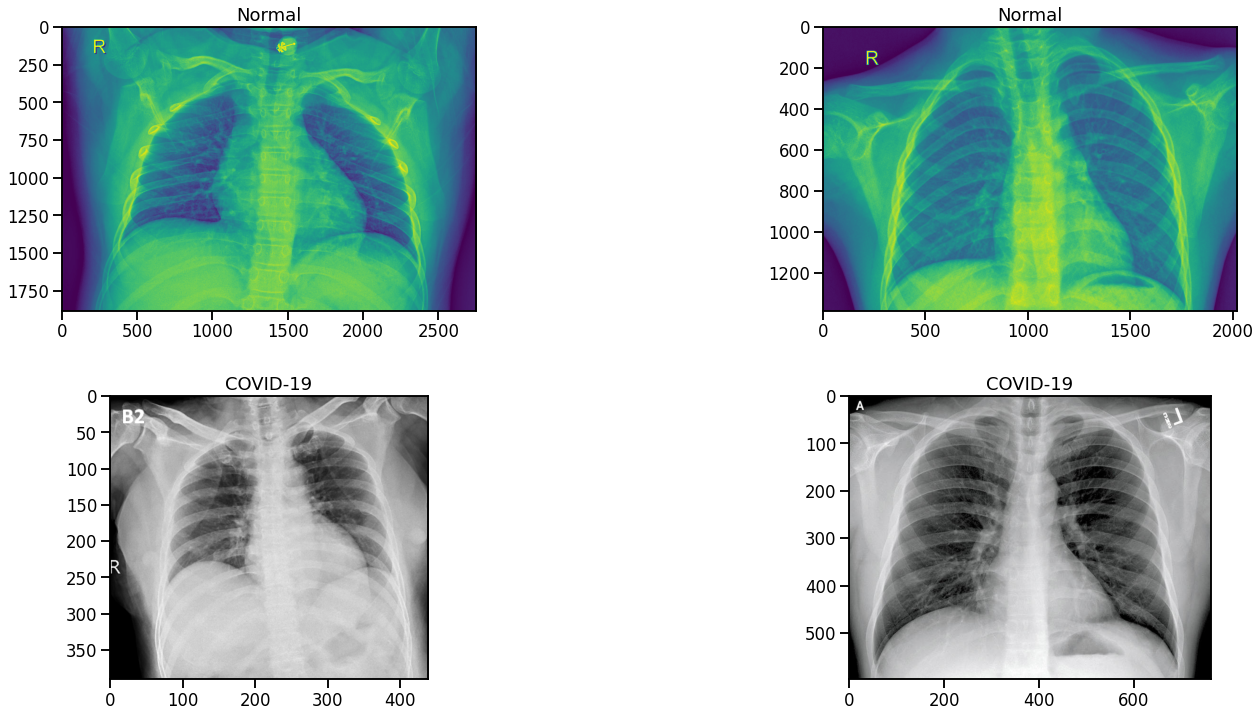

In [6]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(25,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[0]))
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[6]))
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[28]))
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[26]))
plt.title('COVID-19')

Text(0.5, 1.0, 'Category Count')

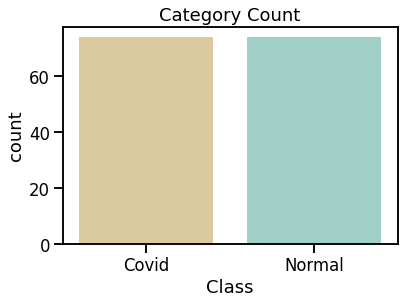

In [9]:
#Category count Plot
sns.countplot(train_df['Class'], palette='BrBG')
plt.title('Category Count')

### Image Processing

In [0]:
# Image to matrix function

def img_to_mtx(data, empty_array):
    for i in data:
        temp_img = image.load_img(i, target_size=(150,150))
        temp_img = img_to_array(temp_img)
        empty_array.append(temp_img)

#empty list
train_imgs = []
test_imgs = []

#Applying Image to Matrix
img_to_mtx(train_df['Path'], train_imgs)
img_to_mtx(test_df['Path'], test_imgs)

#keras preprocessing
train_imgs = preprocess_input(np.array(train_imgs))
test_imgs = preprocess_input(np.array(test_imgs))

### Label Encoding

In [0]:
#String to Numeric Label
train_df['Class'] = train_df['Class'].replace(['Covid','Normal'], [1,0])
test_df['Class'] = test_df['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output
ytrain = to_categorical(train_df['Class'], num_classes=2)

### Implementation of Early Stopping module & Saving Best Model Architecture

In [0]:
#Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

### Deep Neural Network - Implementing CNN

In [0]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(150, 150, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
#overview of deep neural network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23040128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Execution

In [66]:
#Model fitting and tracking historical accuracy / error score
history = model.fit(train_imgs, ytrain, 
          validation_split=0.10, 
          epochs=20, batch_size=32, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Epoch 1/20
5/5 [==============================] - 4s 838ms/step - loss: 5.2166 - accuracy: 0.6767 - val_loss: 0.7661 - val_accuracy: 1.0000
Epoch 2/20
5/5 [==============================] - 4s 815ms/step - loss: 2.2742 - accuracy: 0.8722 - val_loss: 2.7741e-13 - val_accuracy: 1.0000
Epoch 3/20
5/5 [==============================] - 4s 807ms/step - loss: 0.7900 - accuracy: 0.9624 - val_loss: 1.5365 - val_accuracy: 0.9333
Epoch 4/20
5/5 [==============================] - 4s 810ms/step - loss: 0.2489 - accuracy: 0.9850 - val_loss: 2.1996e-11 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 4s 808ms/step - loss: 0.1697 - accuracy: 0.9925 - val_loss: 1.2509e-04 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 3s 670ms/step - loss: 0.1472 - accuracy: 0.9699 - val_loss: 2.6217e-10 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 4s 804ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2643 - val_accuracy: 1.0000
Epoc

### Learning curve over Number of Iterations

Text(0, 0.5, 'Error')

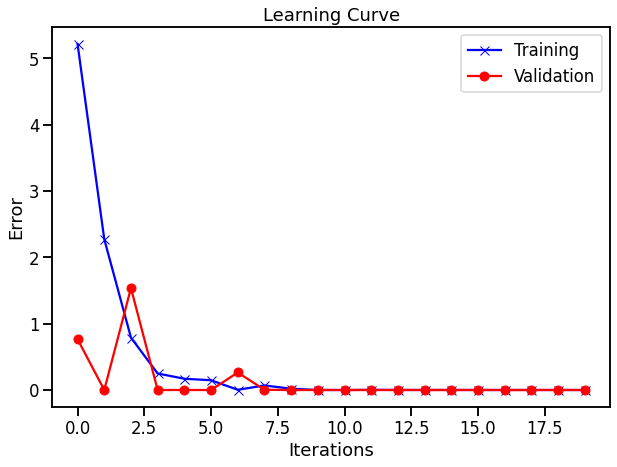

In [67]:
#plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

### Prediction

In [0]:
#prediction on test set
pred = model.predict(test_imgs, batch_size=32)
#pred

#converting Probabilities to labels
label = np.argmax(pred, axis=1)
#label

### Performance Evaluation - Accuracy, Classification Report & Confusion Matrix

In [70]:
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, test_df['Class'].values), '\n')

#precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, test_df['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



Text(0.5, 1.0, 'Confusion Matrix')

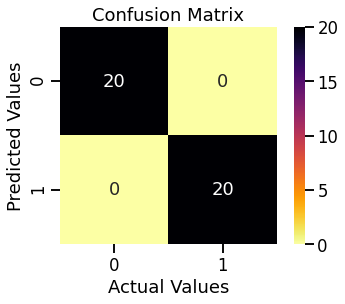

In [79]:
#plotting confusion matrix
sns.heatmap(confusion_matrix(label, test_df['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')